## RAG Agent:

This demo show, use of RAG Agent to query the document. It requires:
- Langchain with chromadb
- StateGraph with RAG Tools

**Imports**

In [14]:
# typing
from typing import TypedDict, Annotated, Sequence

# 
import os

# operator
from operator import add as add_messages

# langchain
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage, HumanMessage

# embeding chroma db
from langchain_chroma import Chroma

# langgraph
from langgraph.graph import StateGraph, START, END

**Model:**
- LLM => temperature zero to minimize hallu
- Embedings => To embed the text from document.

In [15]:
# temperature 0 => Minimize hallucination
llm = ChatOllama(model='llama3.1:latest', temperature=0)

embeddings = OllamaEmbeddings(
    model='nomic-embed-text:latest'
)

**PDF Loading and Embeding**

In [16]:
pdf_path = "Stock_Market_Performance_2024.pdf"

if not os.path.exists(pdf_path):
    raise FileNotFoundError(f'PDF file not found {pdf_path}')

pdf_loader = PyMuPDFLoader(pdf_path)

try:
    pages = pdf_loader.load()
    print(f'PDF has been loaded and has {len(pages)} pages')
except Exception as e:
    print(f'Error loading PDF: {e}')
    raise


PDF has been loaded and has 9 pages


**Splitting Text in PDF:**

In [17]:
# initialize
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

# apply splitter to all pages:
pages_split = text_splitter.split_documents(pages)

**Chromadb Setup:**

In [18]:
persist_directory = './chrome_store'
collection_name = "stock_market"


# if collection doesnt exists create it
if not os.path.exists(persist_directory):
    os.makedirs(persist_directory)


try:
    # now create a vector embedings from page
    vector_store = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=persist_directory,
        collection_name=collection_name
    )
    print(f'Created chromeDB vector store')
except Exception as e:
    print(f'Error setting up embedings: {str(e)}')
    raise


Created chromeDB vector store


**Create a retriver**
- This is a retriver used to fetch similar documents.

In [19]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 5} # no of chunks to return
)

# usage:
# similar_docs =  retriever.invoke(query)
# This returns a list of docs that match.

**Creating a tools for agent:**

In [20]:
@tool
def retriver_tool(query: str) -> str:
    """
    This tool searches and returns information from stock
    market performance 2024 documents
    """
    docs = retriever.invoke(query)

    # if there's no similar doc
    if not docs:
        return 'I found no relevant information in the Stocket Market Performance 2024 Documents.'

    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}: \n{doc.page_content}")
    
    return "\n\n".join(results)


tools = [retriver_tool]

llm = llm.bind_tools(tools=tools)

tools_dict = {our_tool.name: our_tool for our_tool in tools}

**Agent State:**

In [21]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


**Node Function:**

In [22]:
# Conditional edge decider function
def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]

    has_tool_call = hasattr(result, 'tool_calls')
    total_tool_calls = 0
    if has_tool_call:
        total_tool_calls = len(result.tool_calls)
    
    if has_tool_call and total_tool_calls > 0:
        return True
    else:
        return False



def call_llm(state: AgentState) -> AgentState:
    """Function to call LLM with current state"""

    system_prompt = """
    You are an intelligent AI assistant who answers questions about Stock Market Performance in 
    2024 based on the PDF document loaded into your knowledge base. Use the retriever tool 
    available to answer questions about the stock market performance data. You can make multiple
    calls if needed. If you need to look up some information before asking a follow up question, 
    you are allowed to do that! 

    Please always cite the specific parts of the documents you use in your answers.
    """
    system_message = SystemMessage(content=system_prompt)
    messages = list(state['messages'])
    messages = [system_message] + messages

    message = llm.invoke(messages)

    # returns a new message to be appended to reducer
    # Annotated[Sequence[BaseMessage], add_messages]
    return {'messages': [message]}

def take_action(state: AgentState) -> AgentState:
    """Executes tool call from LLM's response."""

    tool_calls = state['messages'][-1].tool_calls

    results = []

    for t in tool_calls:
        # tool name and args
        tool_name = t['name']
        tool_call_id = t['id']
        tool_args = t['args'].get('query', 'No query provided')

        print(f"Calling tool: {tool_name} with {tool_args}")

        # prepare a response from toolcall
        if not tool_name in tools_dict:
            print(f'\nTool {tool_name} doesnt exists')
            result = "Incorrect Tool Name, Please retry and Select Tool From List Of Available Tools"
        else:
            result = tools_dict[tool_name].invoke(tool_args)

        tool_message = ToolMessage(
            tool_call_id=tool_call_id,
            name=tool_name,
            content=str(result)
        )
        results.append(tool_message)

    print('\n Tool Execution Complete, Back to Model.')

    return {'messages': results}

**State graph:**

In [23]:
graph = StateGraph(AgentState)

# nodes
graph.add_node('llm', call_llm)
graph.add_node('retriever_agent', take_action)

# edges
graph.add_conditional_edges(
    'llm',
    should_continue,
    {
        True: 'retriever_agent',
        False: END
    }
)

graph.add_edge('retriever_agent', 'llm')

# entry point
graph.set_entry_point('llm')


**Compile and Visualize Graph:**

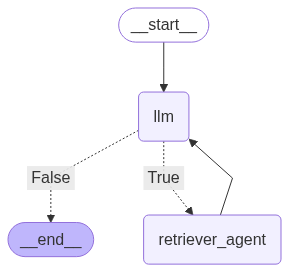

In [24]:
rag_agent = graph.compile()

from IPython.display import Image, display

display(Image(rag_agent.get_graph().draw_mermaid_png()))

**Invoke and Agent:**

Note that this doesnt supports converstation history.

In [27]:
print("\n=== RAG Agent ===")
while True:
    user_input = input('\n User: ')
    print('\n')
    if user_input.lower() in ['exit', 'quit']:
        break

    messages = [HumanMessage(content=user_input)]

    result = rag_agent.invoke({
        'messages': messages
    })

    print("\n=== ANSWER ===")
    print(result['messages'][-1].content)


=== RAG Agent ===


Calling tool: retriver_tool with apple stock performance 2024 key takeaways

 Tool Execution Complete, Back to Model.

=== ANSWER ===
Based on the documents provided, here are the key takeaways about Apple stock in 2024:

* Apple Inc. (AAPL) collectively surged by roughly 64-67% on average in 2024 as part of the "Magnificent 7" group of powerhouse companies.
* The company's stock price rose significantly, with a nearly 40 times expansion in valuation, trading at about 40 times its trailing earnings by the end of 2024 (Document 5).
* Apple's combination of robust stock price growth and relatively modest earnings growth pushed its valuation to a lofty level going into 2025.
* The company's dominance was a key theme in 2024's market climate, driven by technology and growth stocks.

These takeaways are based on the information provided in Documents 3 and 5.


Calling tool: retriver_tool with What was the previous question?

 Tool Execution Complete, Back to Model.

===